In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from dogo.results import get_pred_means_and_vars, get_experiment_details

In [3]:
plt.rc('font', size=16)

# D3RLPY-PAP5

In [26]:
d3rlpy_pap5_datasets = [
    "D3RLPY-PAP5",
    "D3RLPY-PAP5-P0-3",
    "D3RLPY-PAP5-P1-4",
    "D3RLPY-PAP5_100000",
    "D3RLPY-PAP5-P0_25000",
    "D3RLPY-PAP5-P1_25000",
    "D3RLPY-PAP5-P2_25000",
    "D3RLPY-PAP5-P3_25000",
    "D3RLPY-PAP5-P4_25000",
    "D3RLPY-PAP5-P0_100000",
    "D3RLPY-PAP5-P1_100000",
    "D3RLPY-PAP5-P2_100000",
    "D3RLPY-PAP5-P3_100000",
    "D3RLPY-PAP5-P4_100000",
]
d3rlpy_pap5_experiment_datasets = ['D3RLPY-PAP5-P0-3', 'D3RLPY-PAP5-P1-4']
d3rlpy_pap5_experiments = ["MP100", "MP101", "MP102", "MP103", "MP104", "MP105", "MP106", "MP107", "MP108", "MP109", "MP110", "MP111", "MP134", "MP135", "MP136", "MP137", "MP138", "MP139"]#, "MP124", "MP125", "MP126"]

In [30]:
d3rlpy_pap5_preds = {}
d3rlpy_pap5_pred_summary = {}
for exp in d3rlpy_pap5_experiments:
    d3rlpy_pap5_preds[exp] = {}
    
    exp_details = get_experiment_details(exp)
    key = ' - '.join((exp_details.name, exp_details.dataset, f'REx: {exp_details.rex}'))
    for data in d3rlpy_pap5_datasets:
        pred_means, pred_vars = get_pred_means_and_vars(exp, data)

        d3rlpy_pap5_preds[exp][data] = {
            'pred_means': pred_means,
            'pred_vars': pred_vars,
        }

        d3rlpy_pap5_pred_summary[(key, data)] = {
            'experiment': exp_details.name,
            'rex': exp_details.rex,
            'rex_beta': exp_details.rex_beta or 0.,
            'training_dataset': exp_details.dataset,
            'seed': exp_details.seed,
            'mean_pred_means': pred_means.mean(),
            'mean_pred_vars': pred_vars.mean(),
            'median_pred_means': np.percentile(pred_means, 50),
            'median_pred_vars': np.percentile(pred_vars, 50)
        }


In [31]:
d3rlpy_pap5_pred_summary_df = (
    pd.DataFrame().from_dict(d3rlpy_pap5_pred_summary, orient='index').
    reset_index().rename(columns={'level_0': 'key', 'level_1': 'evaluation_dataset'})
)

In [32]:
d3rlpy_pap5_preds_groups = (
    d3rlpy_pap5_pred_summary_df[['rex', 'rex_beta', 'training_dataset', 'evaluation_dataset', 'seed', 'mean_pred_means', 'mean_pred_vars', 'median_pred_means', 'median_pred_vars']].
    groupby(['rex', 'training_dataset', 'evaluation_dataset'])
    # groupby(['rex', 'training_dataset', 'evaluation_dataset'])
)
d3rlpy_pap5_preds_avgs_df = d3rlpy_pap5_preds_groups.mean().reset_index()
d3rlpy_pap5_preds_stds_df = d3rlpy_pap5_preds_groups.std().reset_index().replace(np.NaN, 0)
d3rlpy_pap5_preds_mins_df = d3rlpy_pap5_preds_groups.min().reset_index().replace(np.NaN, 0)
d3rlpy_pap5_preds_maxes_df = d3rlpy_pap5_preds_groups.max().reset_index().replace(np.NaN, 0)

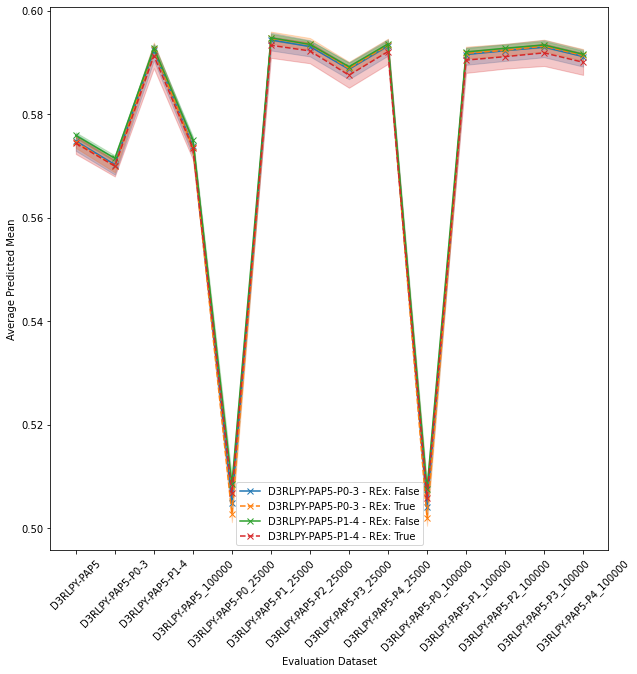

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

metric = 'mean_pred_means'
training_datasets = d3rlpy_pap5_experiment_datasets
evaluation_datasets = d3rlpy_pap5_datasets
for t_ds in training_datasets:
    for rex, rex_beta in [(False, 0.), (True, 10.)]:
        mask = (
            (d3rlpy_pap5_preds_avgs_df['training_dataset'] == t_ds) &
            (d3rlpy_pap5_preds_avgs_df['rex'] == rex) &
            (d3rlpy_pap5_preds_avgs_df['rex_beta'] == rex_beta) &
            # (d3rlpy_pap5_preds_avgs_df['seed'] == 4321) &
            (d3rlpy_pap5_preds_avgs_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
        )
        plot_means = d3rlpy_pap5_preds_avgs_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        plot_mins = d3rlpy_pap5_preds_mins_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        plot_maxes = d3rlpy_pap5_preds_maxes_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        label = f'{t_ds} - REx: {rex}'
        p = ax.plot(evaluation_datasets, plot_means, label=label, marker='x', ls='--' if rex else '-')
        ax.fill_between(evaluation_datasets, plot_mins, plot_maxes, color=p[0].get_color(), alpha=0.25)
ax.set_xticks(ax.get_xticks(), evaluation_datasets, rotation=45)
ax.set_xlabel('Evaluation Dataset')
ax.set_ylabel('Average Predicted Mean')
ax.legend()

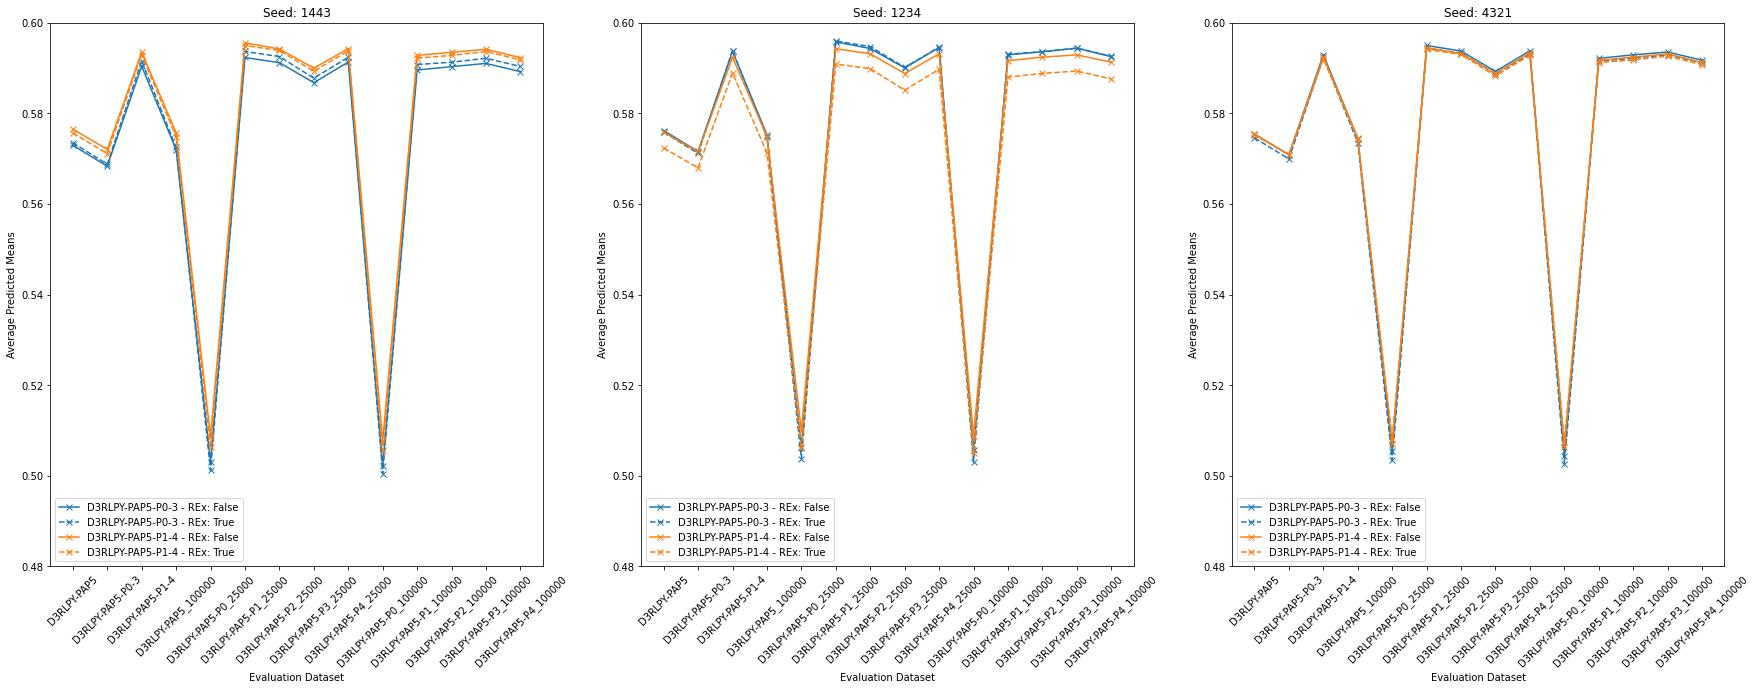

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

metric = 'mean_pred_means'
training_datasets = ['D3RLPY-PAP5-P0-3', 'D3RLPY-PAP5-P1-4']
evaluation_datasets = d3rlpy_pap5_datasets

for i, seed in enumerate([1443, 1234, 4321]):
    for t_ds in training_datasets:
        for rex, rex_beta in [(False, 0.), (True, 10.)]:
            mask = (
                (d3rlpy_pap5_pred_summary_df['training_dataset'] == t_ds) &
                (d3rlpy_pap5_pred_summary_df['rex'] == rex) &
                (d3rlpy_pap5_preds_avgs_df['rex_beta'] == rex_beta) &
                (d3rlpy_pap5_pred_summary_df['seed'] == seed) &
                (d3rlpy_pap5_pred_summary_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
            )
            plot_vals = d3rlpy_pap5_pred_summary_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
            label = f'{t_ds} - REx: {rex}'
            p = ax[i].plot(evaluation_datasets, plot_vals, label=label, marker='x', ls='--' if rex else '-', c=p[0].get_color() if rex else None)
    ax[i].set_xticks(ax[i].get_xticks(), evaluation_datasets, rotation=45)
    ax[i].set_title(f'Seed: {seed}')
    ax[i].set_xlabel('Evaluation Dataset')
    ax[i].set_ylabel('Average Predicted Means')
    ax[i].set_ylim(0.48, 0.6)
    ax[i].legend()

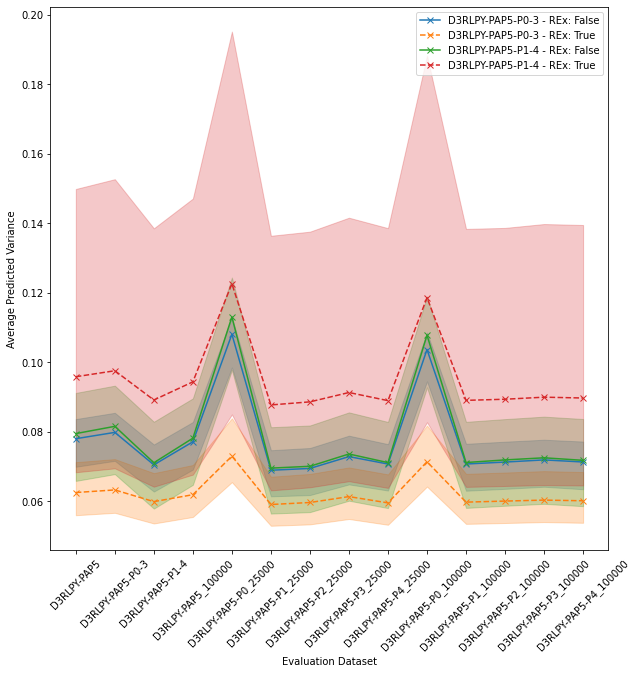

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

metric = 'mean_pred_vars'
training_datasets = d3rlpy_pap5_experiment_datasets
evaluation_datasets = d3rlpy_pap5_datasets
for t_ds in training_datasets:
    for rex, rex_beta in [(False, 0.), (True, 10.)]:
        mask = (
            (d3rlpy_pap5_preds_avgs_df['training_dataset'] == t_ds) &
            (d3rlpy_pap5_preds_avgs_df['rex'] == rex) &
            (d3rlpy_pap5_preds_avgs_df['rex_beta'] == rex_beta) &
            (d3rlpy_pap5_preds_avgs_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
        )
        plot_means = d3rlpy_pap5_preds_avgs_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        plot_mins = d3rlpy_pap5_preds_mins_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        plot_maxes = d3rlpy_pap5_preds_maxes_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        label = f'{t_ds} - REx: {rex}'
        p = ax.plot(evaluation_datasets, plot_means, label=label, marker='x', ls='--' if rex else '-')
        ax.fill_between(evaluation_datasets, plot_mins, plot_maxes, color=p[0].get_color(), alpha=0.25)
ax.set_xticks(ax.get_xticks(), evaluation_datasets, rotation=45)
ax.set_xlabel('Evaluation Dataset')
ax.set_ylabel('Average Predicted Variance')
ax.legend()

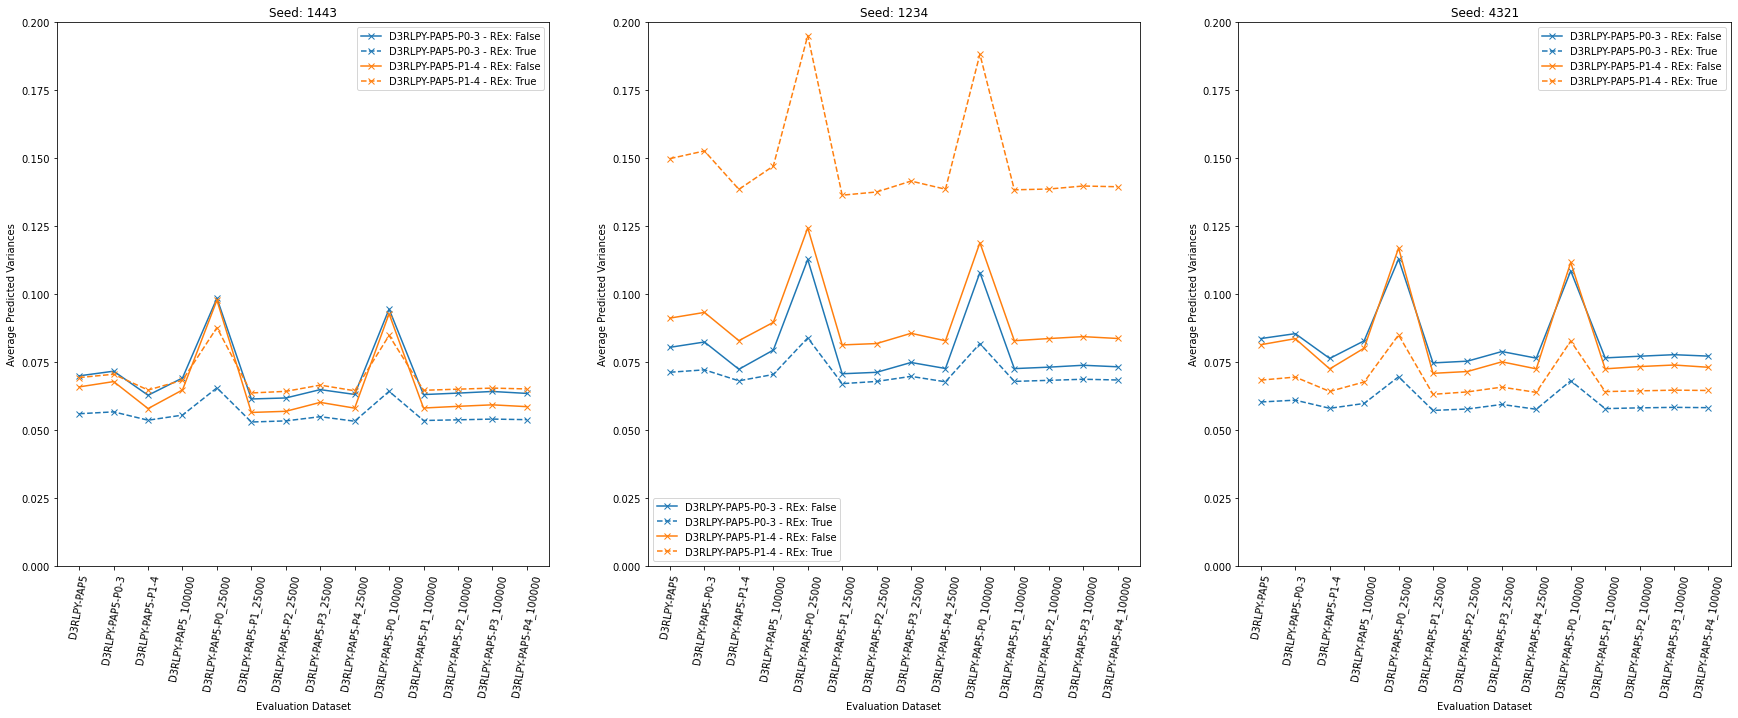

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

metric = 'mean_pred_vars'
training_datasets = ['D3RLPY-PAP5-P0-3', 'D3RLPY-PAP5-P1-4']
evaluation_datasets = d3rlpy_pap5_datasets

for i, seed in enumerate([1443, 1234, 4321]):
    for t_ds in training_datasets:
        for rex, rex_beta in [(False, 0.), (True, 10.)]:
            mask = (
                (d3rlpy_pap5_pred_summary_df['training_dataset'] == t_ds) &
                (d3rlpy_pap5_pred_summary_df['rex'] == rex) &
                (d3rlpy_pap5_pred_summary_df['rex_beta'] == rex_beta) &
                (d3rlpy_pap5_pred_summary_df['seed'] == seed) &
                (d3rlpy_pap5_pred_summary_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
            )
            plot_vals = d3rlpy_pap5_pred_summary_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
            label = f'{t_ds} - REx: {rex}'
            p = ax[i].plot(evaluation_datasets, plot_vals, label=label, marker='x', ls='--' if rex else '-', c=p[0].get_color() if rex else None)
    ax[i].set_xticks(ax[i].get_xticks(), evaluation_datasets, rotation=80)
    ax[i].set_title(f'Seed: {seed}')
    ax[i].set_xlabel('Evaluation Dataset')
    ax[i].set_ylabel('Average Predicted Variances')
    ax[i].set_ylim(0, 0.2)
    ax[i].legend()

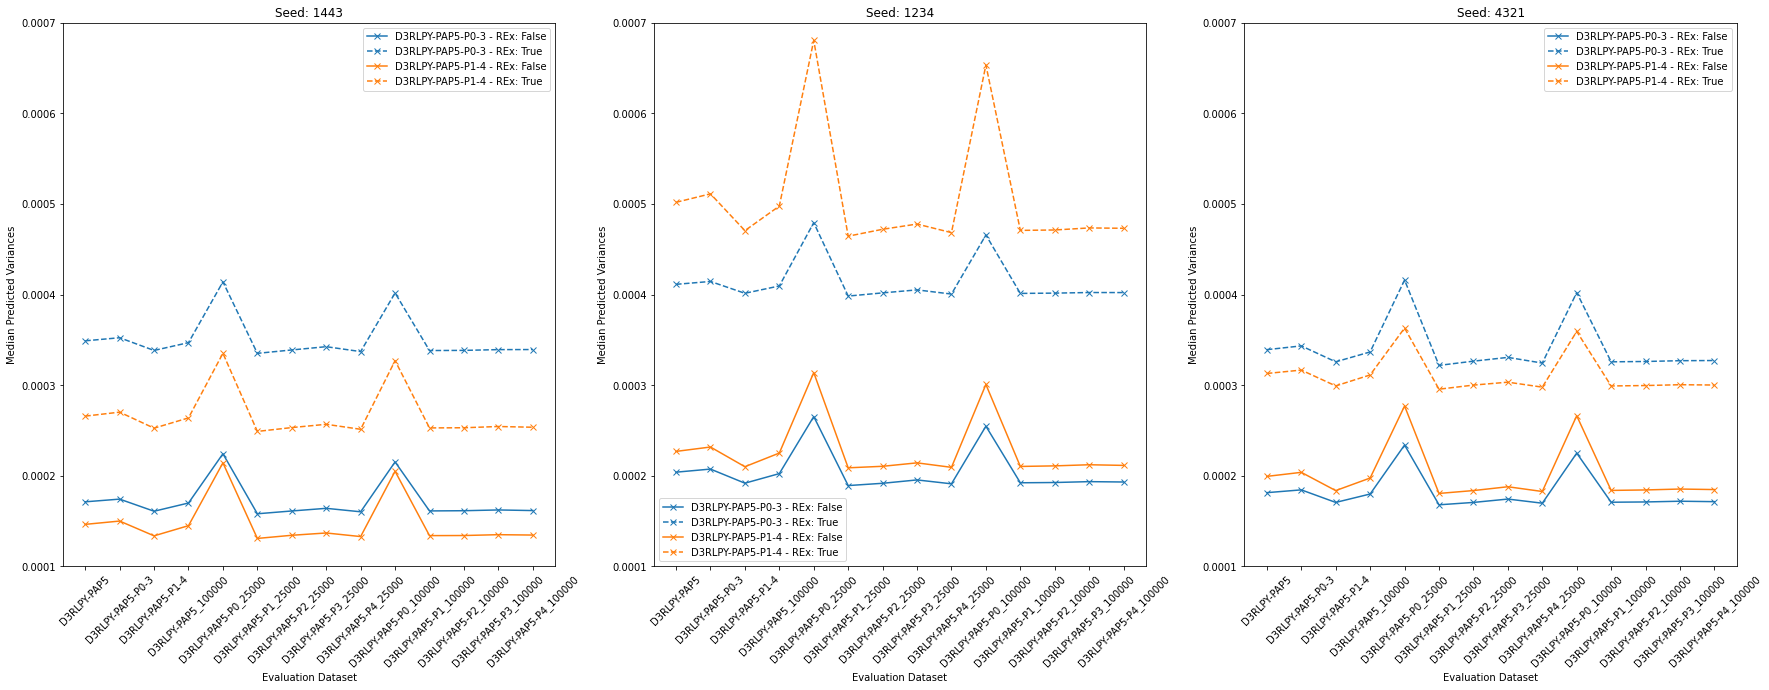

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

metric = 'median_pred_vars'
training_datasets = ['D3RLPY-PAP5-P0-3', 'D3RLPY-PAP5-P1-4']
evaluation_datasets = d3rlpy_pap5_datasets

for i, seed in enumerate([1443, 1234, 4321]):
    for t_ds in training_datasets:
        for rex, rex_beta in [(False, 0.), (True, 10.)]:
            mask = (
                (d3rlpy_pap5_pred_summary_df['training_dataset'] == t_ds) &
                (d3rlpy_pap5_pred_summary_df['rex'] == rex) &
                (d3rlpy_pap5_pred_summary_df['rex_beta'] == rex_beta) &
                (d3rlpy_pap5_pred_summary_df['seed'] == seed) &
                (d3rlpy_pap5_pred_summary_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
            )
            plot_vals = d3rlpy_pap5_pred_summary_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
            label = f'{t_ds} - REx: {rex}'
            p = ax[i].plot(evaluation_datasets, plot_vals, label=label, marker='x', ls='--' if rex else '-', c=p[0].get_color() if rex else None)
    ax[i].set_xticks(ax[i].get_xticks(), evaluation_datasets, rotation=45)
    ax[i].set_title(f'Seed: {seed}')
    ax[i].set_xlabel('Evaluation Dataset')
    ax[i].set_ylabel('Median Predicted Variances')
    ax[i].set_ylim(0.0001, 0.0007)
    ax[i].legend()

In [13]:
exp_1 = 'MP104'
exp_2 = 'MP105'
val_arr, experiment_arr, dataset_arr = np.array([]), np.array([]), np.array([])
for data in d3rlpy_pap5_datasets:
    vals_1 = d3rlpy_pap5_preds[exp_1][data]['pred_vars'].mean(axis=0).flatten()
    vals_2 = d3rlpy_pap5_preds[exp_2][data]['pred_vars'].mean(axis=0).flatten()

    val_arr = np.hstack((val_arr, np.log(vals_1), np.log(vals_2)))
    experiment_arr = np.hstack((experiment_arr, np.full(len(vals_1), exp_1), np.full(len(vals_2), exp_2)))
    dataset_arr = np.hstack((dataset_arr, np.full(len(vals_1), data), np.full(len(vals_2), data)))

In [14]:
vals_df = pd.DataFrame({
    'values': val_arr,
    'experiment': experiment_arr,
    'dataset': dataset_arr,
})

<AxesSubplot:xlabel='dataset', ylabel='values'>

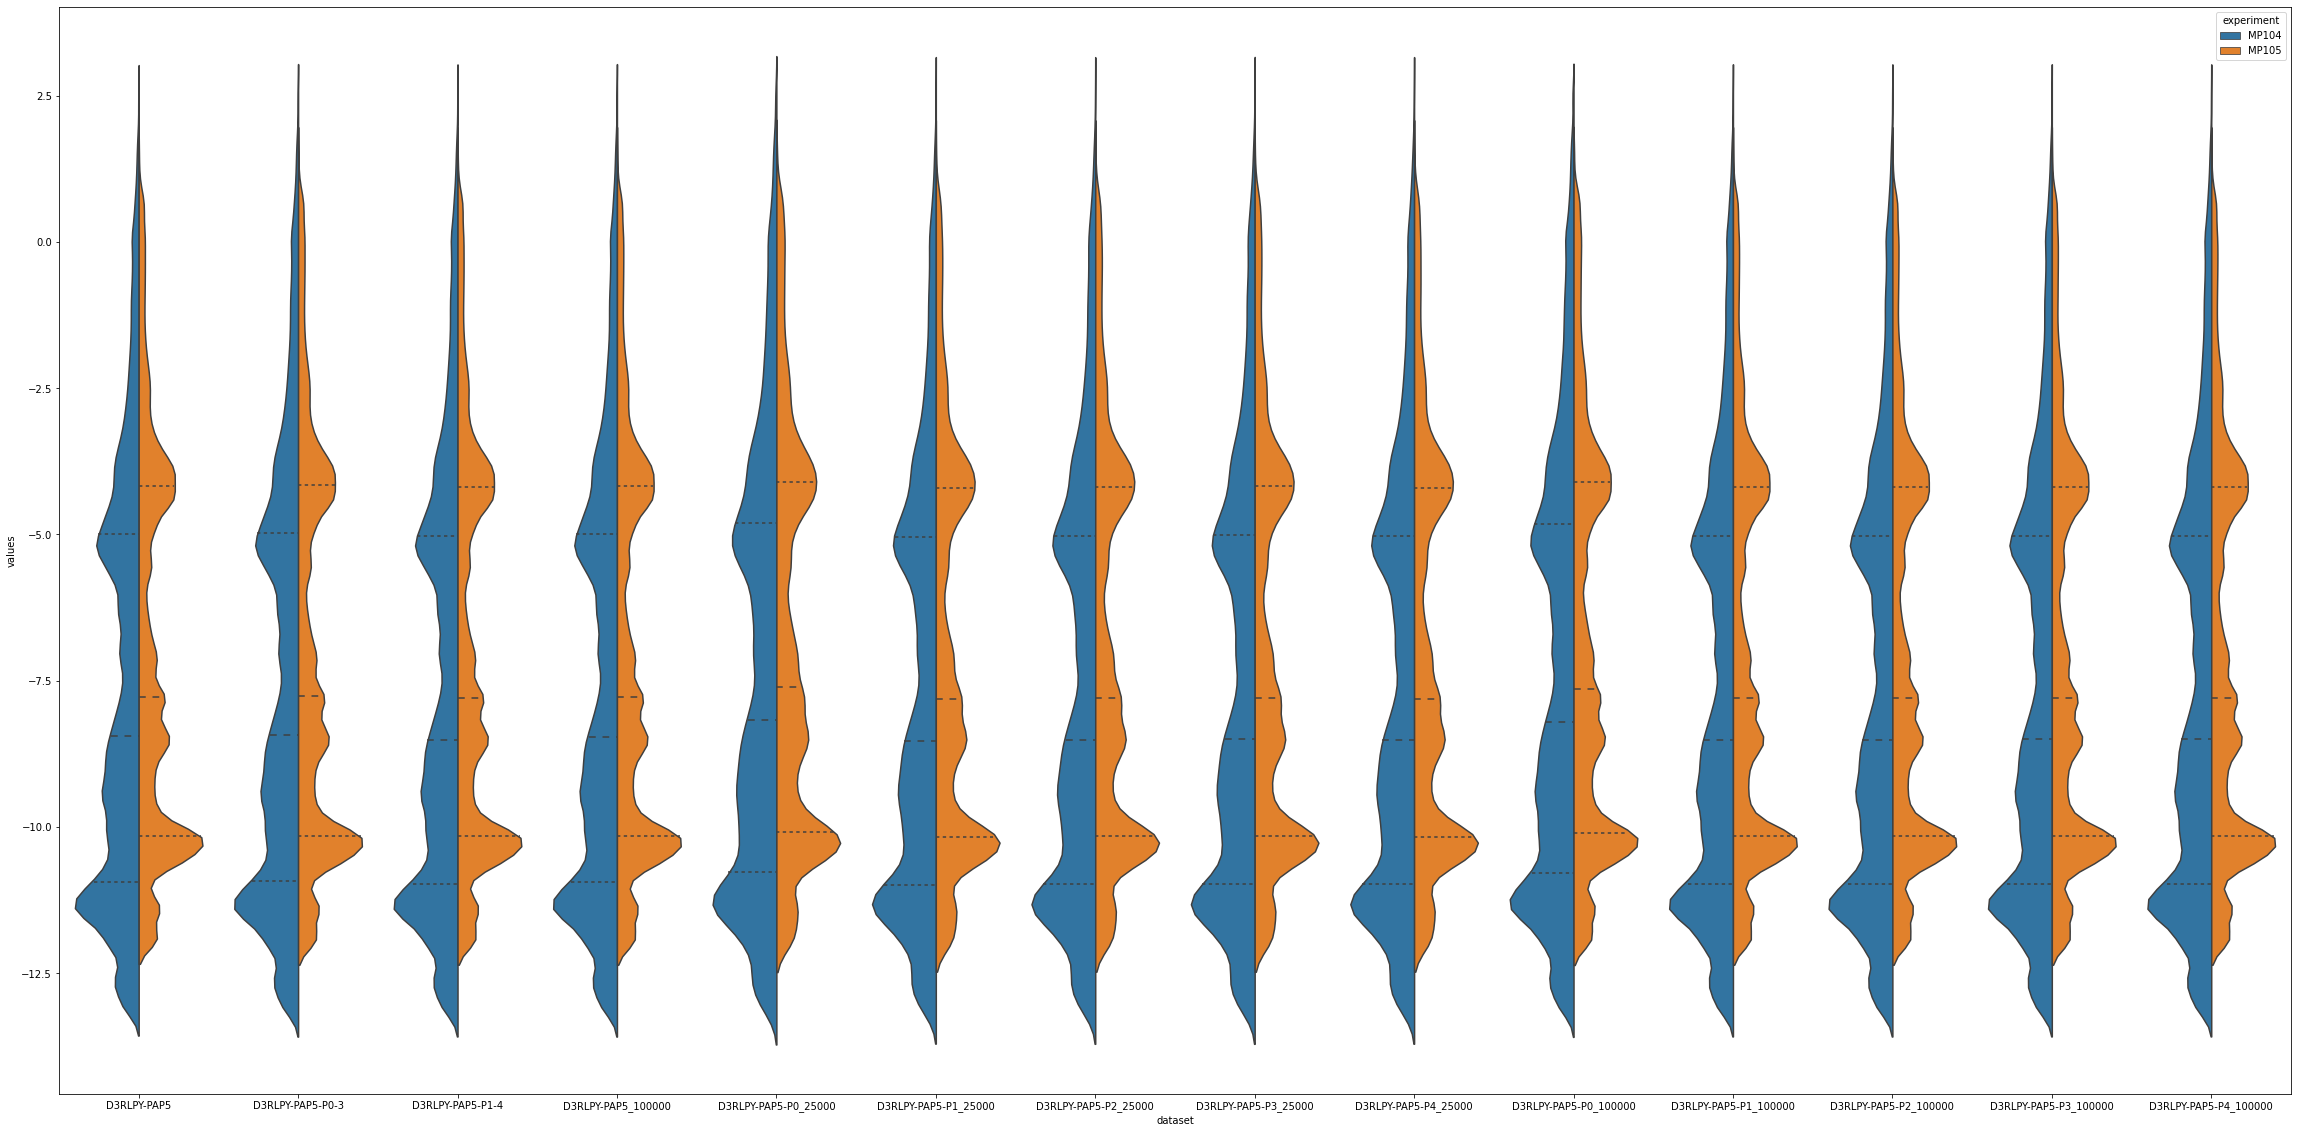

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(40,20))
sns.violinplot(
    x='dataset', y='values', hue='experiment', data=vals_df, split=True, scale="count", inner="quartile"
)

# D3RLPY-MP1

In [16]:
d3rlpy_mp1_datasets = [
    "D3RLPY-MP1",
    "D3RLPY-MP1-P0-3",
    "D3RLPY-MP1-P1-4",
    "D3RLPY-MP1_100000",
    "D3RLPY-MP1-P0_25000",
    "D3RLPY-MP1-P1_25000",
    "D3RLPY-MP1-P2_25000",
    "D3RLPY-MP1-P3_25000",
    "D3RLPY-MP1-P4_25000",
    "D3RLPY-MP1-P0_100000",
    "D3RLPY-MP1-P1_100000",
    "D3RLPY-MP1-P2_100000",
    "D3RLPY-MP1-P3_100000",
    "D3RLPY-MP1-P4_100000",
]
d3rlpy_mp1_experiment_datasets = ['D3RLPY-MP1-P0-3', 'D3RLPY-MP1-P1-4']
d3rlpy_mp1_experiments = ["MP112", "MP113", "MP114", "MP115", "MP116", "MP117", "MP118", "MP119", "MP120", "MP121", "MP122", "MP123"]

In [17]:
d3rlpy_mp1_preds = {}
d3rlpy_mp1_pred_summary = {}
for exp in d3rlpy_mp1_experiments:
    d3rlpy_mp1_preds[exp] = {}
    
    exp_details = get_experiment_details(exp)
    key = ' - '.join((exp_details.name, exp_details.dataset, f'REx: {exp_details.rex}'))
    for data in d3rlpy_mp1_datasets:
        pred_means, pred_vars = get_pred_means_and_vars(exp, data)

        d3rlpy_mp1_preds[exp][data] = {
            'pred_means': pred_means,
            'pred_vars': pred_vars,
        }

        d3rlpy_mp1_pred_summary[(key, data)] = {
            'rex': exp_details.rex,
            'training_dataset': exp_details.dataset,
            'seed': exp_details.seed,
            'mean_pred_means': pred_means.mean(),
            'mean_pred_vars': pred_vars.mean(),
            'std_pred_vars': pred_vars.std(),
            'median_pred_means': np.percentile(pred_means, 50),
            'median_pred_vars': np.percentile(pred_vars, 50)
        }

In [18]:
d3rlpy_mp1_pred_summary_df = (
    pd.DataFrame().from_dict(d3rlpy_mp1_pred_summary, orient='index')[['rex', 'training_dataset', 'seed', 'mean_pred_means', 'mean_pred_vars', 'std_pred_vars', 'median_pred_means', 'median_pred_vars']].
    reset_index().rename(columns={'level_0': 'key', 'level_1': 'evaluation_dataset'})
)

In [19]:
d3rlpy_mp1_preds_groups = (
    d3rlpy_mp1_pred_summary_df[['rex', 'training_dataset', 'evaluation_dataset', 'seed', 'mean_pred_means', 'mean_pred_vars', 'std_pred_vars', 'median_pred_means', 'median_pred_vars']].
    groupby(['rex', 'training_dataset', 'evaluation_dataset'])
    # groupby(['rex', 'training_dataset', 'evaluation_dataset'])
)
d3rlpy_mp1_preds_avgs_df = d3rlpy_mp1_preds_groups.mean().reset_index()
d3rlpy_mp1_preds_stds_df = d3rlpy_mp1_preds_groups.std().reset_index().replace(np.NaN, 0)
d3rlpy_mp1_preds_mins_df = d3rlpy_mp1_preds_groups.min().reset_index().replace(np.NaN, 0)
d3rlpy_mp1_preds_maxes_df = d3rlpy_mp1_preds_groups.max().reset_index().replace(np.NaN, 0)

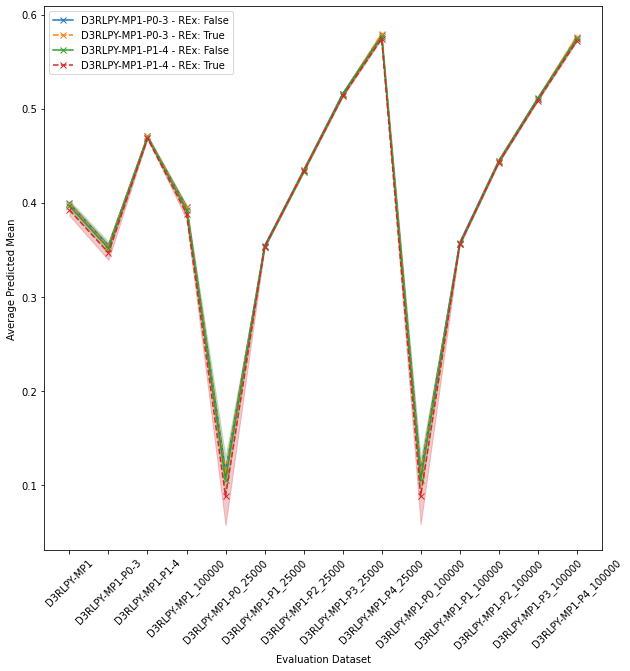

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

metric = 'mean_pred_means'
training_datasets = d3rlpy_mp1_experiment_datasets
evaluation_datasets = d3rlpy_mp1_datasets
for t_ds in training_datasets:
    for rex in [False, True]:
        mask = (
            (d3rlpy_mp1_preds_avgs_df['training_dataset'] == t_ds) &
            (d3rlpy_mp1_preds_avgs_df['rex'] == rex) &
            # (d3rlpy_mp1_preds_avgs_df['seed'] == 4321) &
            (d3rlpy_mp1_preds_avgs_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
        )
        plot_means = d3rlpy_mp1_preds_avgs_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        plot_mins = d3rlpy_mp1_preds_mins_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        plot_maxes = d3rlpy_mp1_preds_maxes_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        label = f'{t_ds} - REx: {rex}'
        p = ax.plot(evaluation_datasets, plot_means, label=label, marker='x', ls='--' if rex else '-')
        ax.fill_between(evaluation_datasets, plot_mins, plot_maxes, color=p[0].get_color(), alpha=0.25)
ax.set_xticks(ax.get_xticks(), evaluation_datasets, rotation=45)
ax.set_xlabel('Evaluation Dataset')
ax.set_ylabel('Average Predicted Mean')
ax.legend()

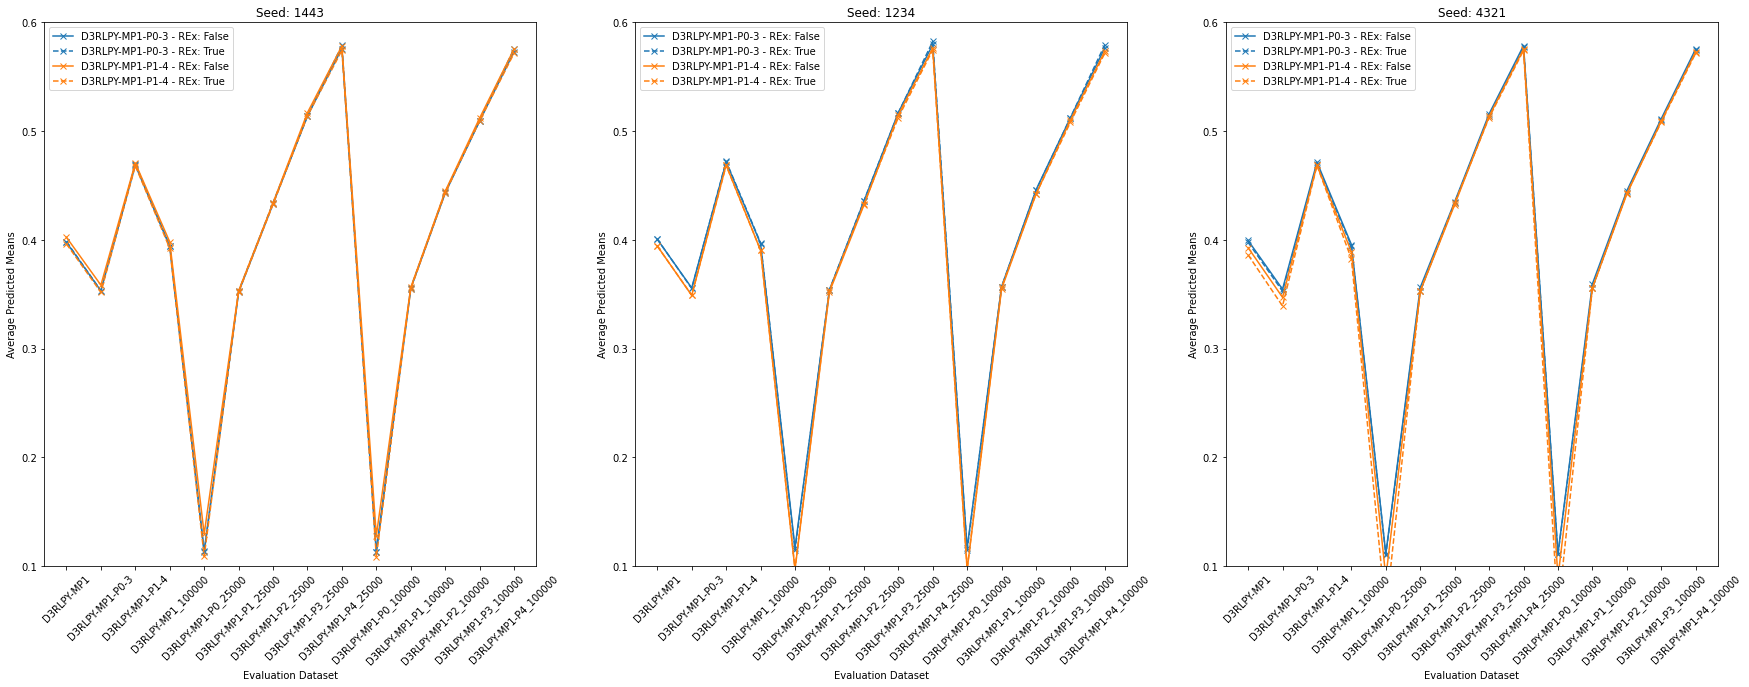

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

metric = 'mean_pred_means'
training_datasets = ['D3RLPY-MP1-P0-3', 'D3RLPY-MP1-P1-4']
evaluation_datasets = d3rlpy_mp1_datasets

for i, seed in enumerate([1443, 1234, 4321]):
    for t_ds in training_datasets:
        for rex in [False, True]:
            mask = (
                (d3rlpy_mp1_pred_summary_df['training_dataset'] == t_ds) &
                (d3rlpy_mp1_pred_summary_df['rex'] == rex) &
                (d3rlpy_mp1_pred_summary_df['seed'] == seed) &
                (d3rlpy_mp1_pred_summary_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
            )
            plot_vals = d3rlpy_mp1_pred_summary_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
            label = f'{t_ds} - REx: {rex}'
            p = ax[i].plot(evaluation_datasets, plot_vals, label=label, marker='x', ls='--' if rex else '-', c=p[0].get_color() if rex else None)
    ax[i].set_xticks(ax[i].get_xticks(), evaluation_datasets, rotation=45)
    ax[i].set_title(f'Seed: {seed}')
    ax[i].set_xlabel('Evaluation Dataset')
    ax[i].set_ylabel('Average Predicted Means')
    ax[i].set_ylim(0.1, 0.6)
    ax[i].legend()

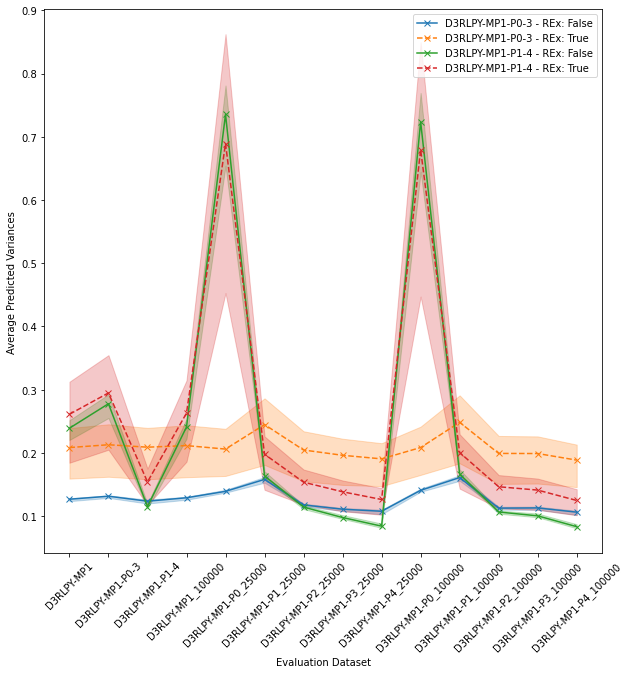

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

metric = 'mean_pred_vars'
training_datasets = d3rlpy_mp1_experiment_datasets
evaluation_datasets = d3rlpy_mp1_datasets
for t_ds in training_datasets:
    for rex in [False, True]:
        mask = (
            (d3rlpy_mp1_preds_avgs_df['training_dataset'] == t_ds) &
            (d3rlpy_mp1_preds_avgs_df['rex'] == rex) &
            # (d3rlpy_mp1_preds_avgs_df['seed'] == 4321) &
            (d3rlpy_mp1_preds_avgs_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
        )
        plot_means = d3rlpy_mp1_preds_avgs_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        plot_mins = d3rlpy_mp1_preds_mins_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        plot_maxes = d3rlpy_mp1_preds_maxes_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        label = f'{t_ds} - REx: {rex}'
        p = ax.plot(evaluation_datasets, plot_means, label=label, marker='x', ls='--' if rex else '-')
        ax.fill_between(evaluation_datasets, plot_mins, plot_maxes, color=p[0].get_color(), alpha=0.25)
ax.set_xticks(ax.get_xticks(), evaluation_datasets, rotation=45)
ax.set_xlabel('Evaluation Dataset')
ax.set_ylabel('Average Predicted Variances')
ax.legend()

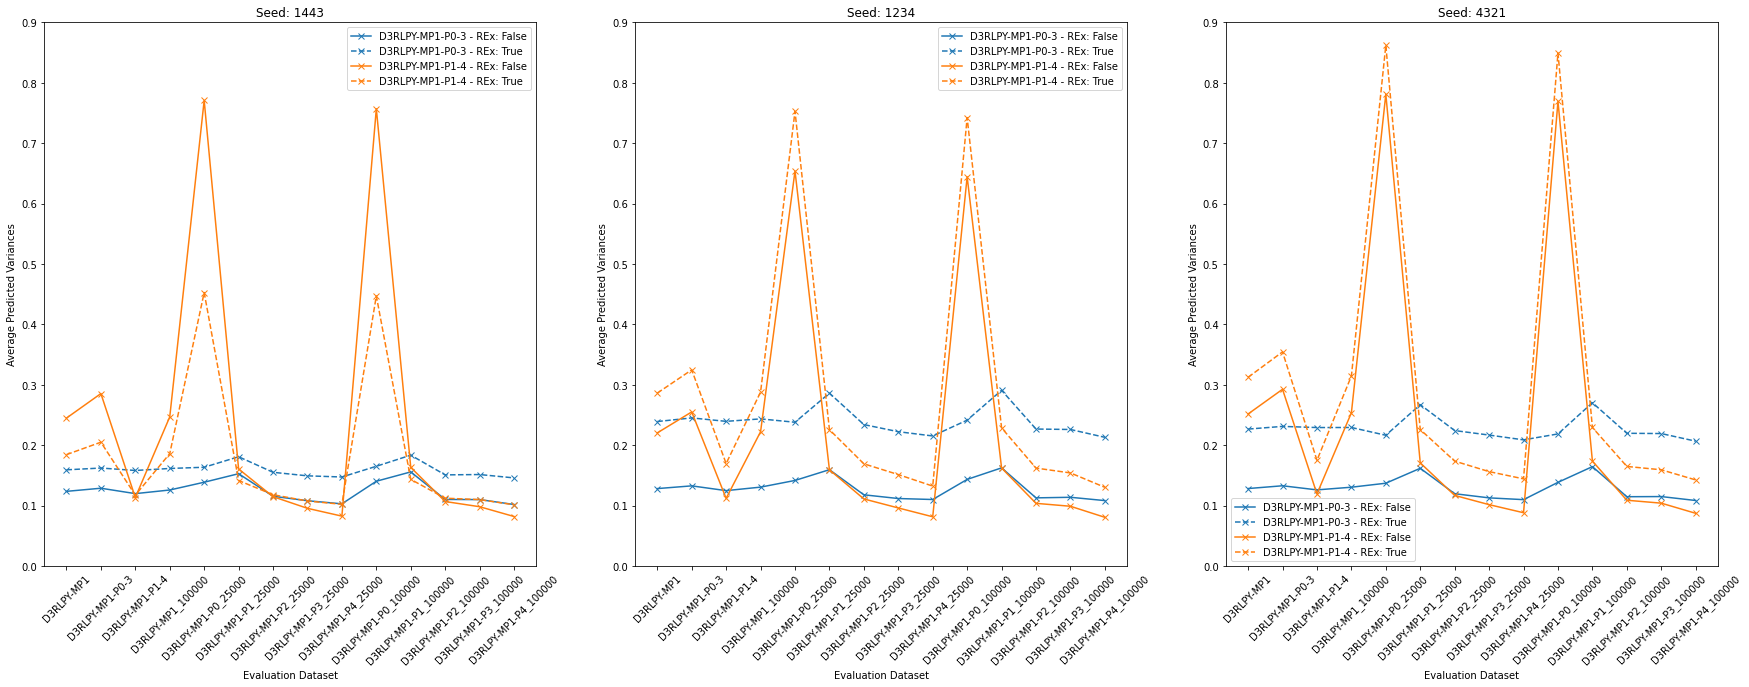

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

metric = 'mean_pred_vars'
training_datasets = ['D3RLPY-MP1-P0-3', 'D3RLPY-MP1-P1-4']
evaluation_datasets = d3rlpy_mp1_datasets

for i, seed in enumerate([1443, 1234, 4321]):
    for t_ds in training_datasets:
        for rex in [False, True]:
            mask = (
                (d3rlpy_mp1_pred_summary_df['training_dataset'] == t_ds) &
                (d3rlpy_mp1_pred_summary_df['rex'] == rex) &
                (d3rlpy_mp1_pred_summary_df['seed'] == seed) &
                (d3rlpy_mp1_pred_summary_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
            )
            plot_vals = d3rlpy_mp1_pred_summary_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
            label = f'{t_ds} - REx: {rex}'
            p = ax[i].plot(evaluation_datasets, plot_vals, label=label, marker='x', ls='--' if rex else '-', c=p[0].get_color() if rex else None)
    ax[i].set_xticks(ax[i].get_xticks(), evaluation_datasets, rotation=45)
    ax[i].set_title(f'Seed: {seed}')
    ax[i].set_xlabel('Evaluation Dataset')
    ax[i].set_ylabel('Average Predicted Variances')
    ax[i].set_ylim(0, 0.9)
    ax[i].legend()

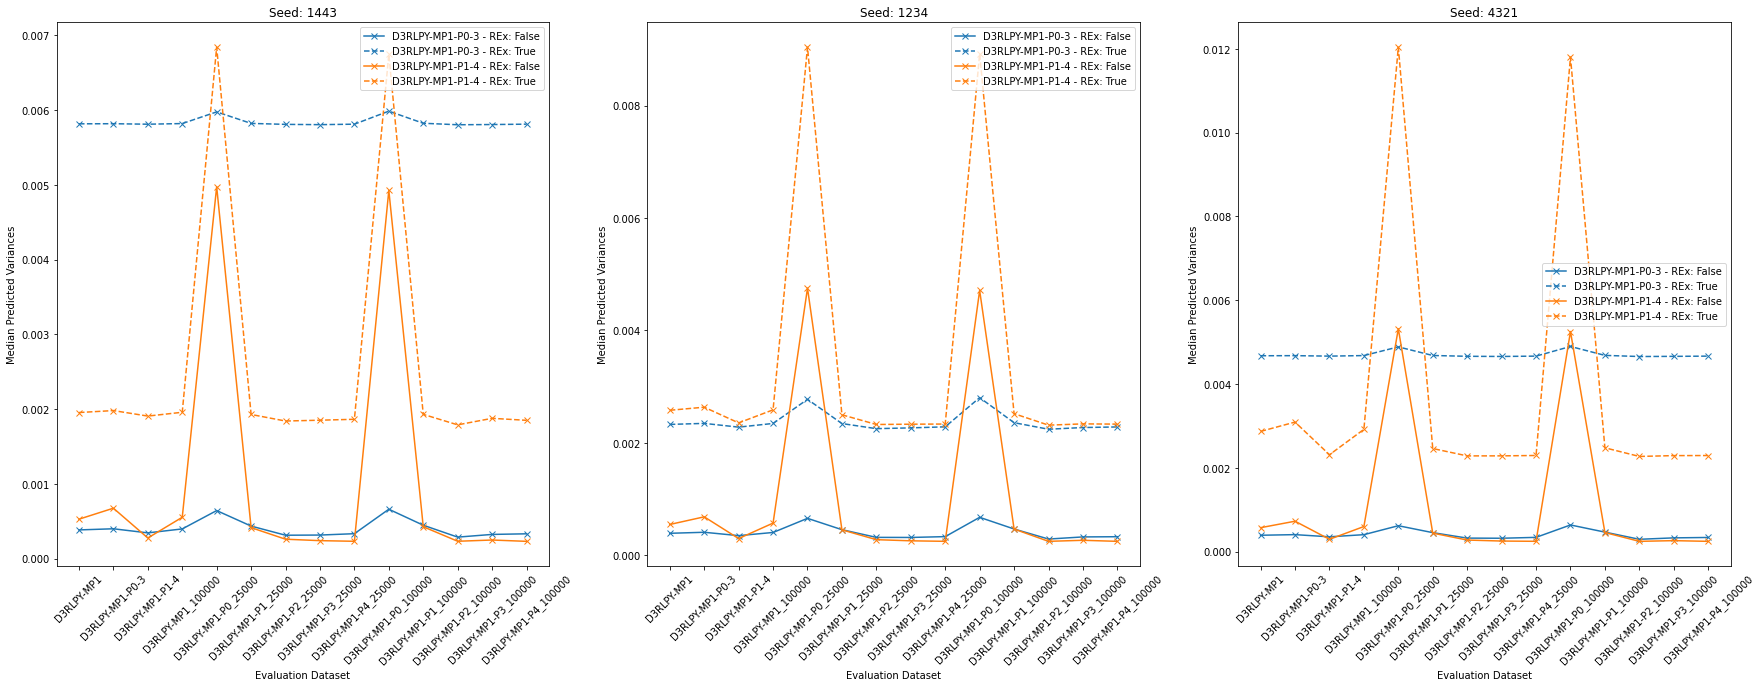

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

metric = 'median_pred_vars'
training_datasets = ['D3RLPY-MP1-P0-3', 'D3RLPY-MP1-P1-4']
evaluation_datasets = d3rlpy_mp1_datasets

for i, seed in enumerate([1443, 1234, 4321]):
    for t_ds in training_datasets:
        for rex in [False, True]:
            mask = (
                (d3rlpy_mp1_pred_summary_df['training_dataset'] == t_ds) &
                (d3rlpy_mp1_pred_summary_df['rex'] == rex) &
                (d3rlpy_mp1_pred_summary_df['seed'] == seed) &
                (d3rlpy_mp1_pred_summary_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
            )
            plot_vals = d3rlpy_mp1_pred_summary_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
            label = f'{t_ds} - REx: {rex}'
            p = ax[i].plot(evaluation_datasets, plot_vals, label=label, marker='x', ls='--' if rex else '-', c=p[0].get_color() if rex else None)
    ax[i].set_xticks(ax[i].get_xticks(), evaluation_datasets, rotation=45)
    ax[i].set_title(f'Seed: {seed}')
    ax[i].set_xlabel('Evaluation Dataset')
    ax[i].set_ylabel('Median Predicted Variances')
    # ax[i].set_ylim(0, 0.9)
    ax[i].legend()

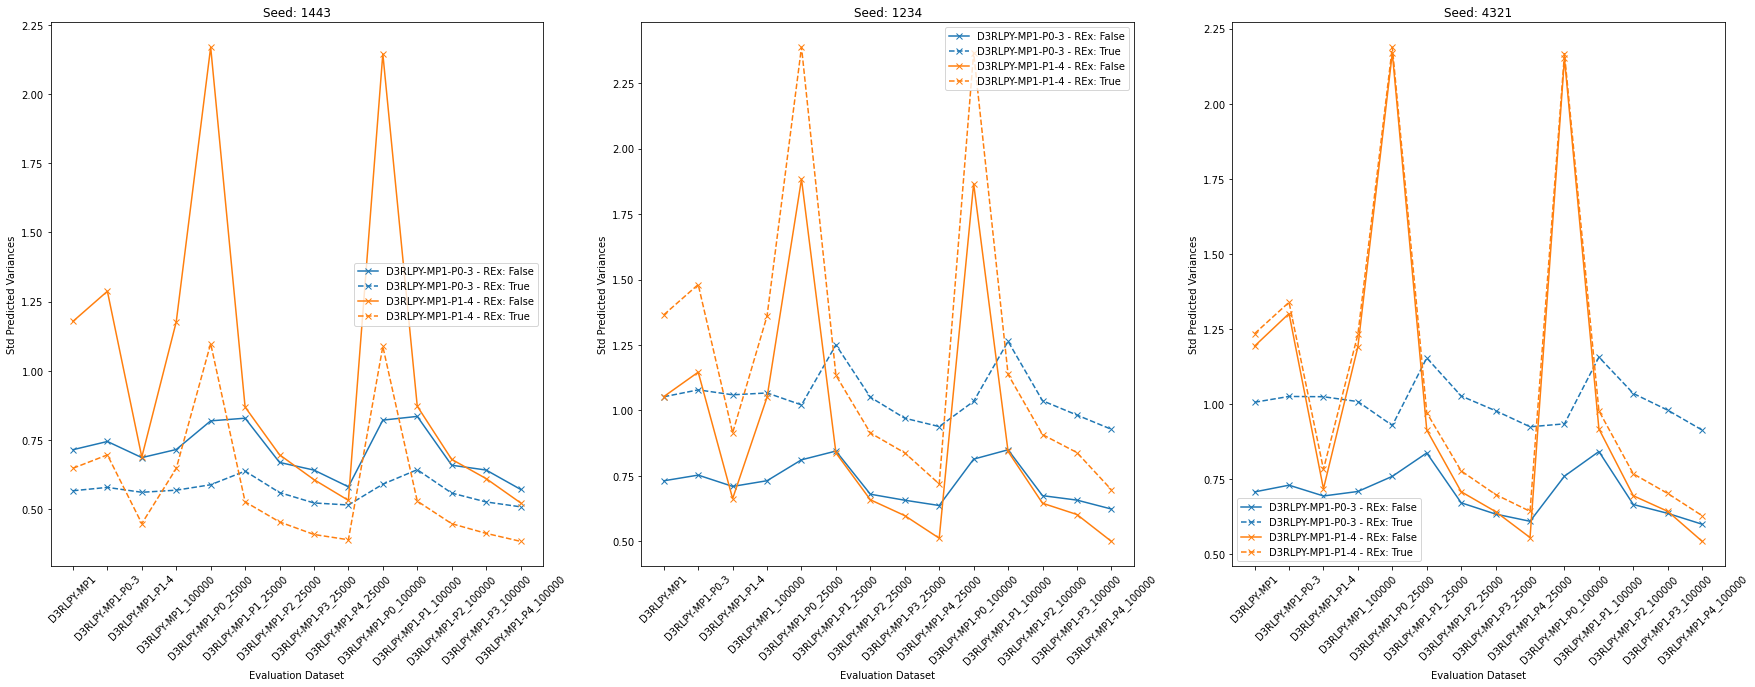

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

metric = 'std_pred_vars'
training_datasets = ['D3RLPY-MP1-P0-3', 'D3RLPY-MP1-P1-4']
evaluation_datasets = d3rlpy_mp1_datasets

for i, seed in enumerate([1443, 1234, 4321]):
    for t_ds in training_datasets:
        for rex in [False, True]:
            mask = (
                (d3rlpy_mp1_pred_summary_df['training_dataset'] == t_ds) &
                (d3rlpy_mp1_pred_summary_df['rex'] == rex) &
                (d3rlpy_mp1_pred_summary_df['seed'] == seed) &
                (d3rlpy_mp1_pred_summary_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
            )
            plot_vals = d3rlpy_mp1_pred_summary_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
            label = f'{t_ds} - REx: {rex}'
            p = ax[i].plot(evaluation_datasets, plot_vals, label=label, marker='x', ls='--' if rex else '-', c=p[0].get_color() if rex else None)
    ax[i].set_xticks(ax[i].get_xticks(), evaluation_datasets, rotation=45)
    ax[i].set_title(f'Seed: {seed}')
    ax[i].set_xlabel('Evaluation Dataset')
    ax[i].set_ylabel('Std Predicted Variances')
    # ax[i].set_ylim(0, 0.9)
    ax[i].legend()